# Install Kaggle API
In this notebook we we be using the kaggle api to download the sign-language-mnist dataset we are going to be using in this notebook. 

In order to download the sign-language-mnist dataset from kaggle, you first have to sign-up with kaggel.com, then download the api key from your account and then upload it with the kaggle auth helper function.  

For more information on have to create account or downloading the api key, please use search on goolge.

Note: Please make sure to store you api keys in a safe place.

In [1]:
kag = !pip list | grep kaggle
if len(kag) == 0:
  ! pip install kaggle
else:
  print('Kaggle api already installed')

Kaggle api already installed


In [0]:
# Helper function for uploading the kaggle auth key and moving it to the .kaggle
# directory for using with the kaggle api
def kaggle_auth():
  import os
  
  if not os.path.exists('/root/.kaggle/'):
    os.mkdir('/root/.kaggle')
  os.chdir('/root/.kaggle/')
  print(os.getcwd())

  if os.path.exists('/root/.kaggle/kaggle.json'):
    print('kaggle token exists')
  else:
    # upload the kaggle token to /content
    from google.colab import files
    print('Please upload your kaggle.json file')
    file = files.upload()
    token = list(file.keys())[0]
    os.rename(os.getcwd()+'/'+token, '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)
    print('Uploaded kaggle token')

In [3]:
kaggle_auth()

/root/.kaggle
Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Uploaded kaggle token


In [4]:
# searchingthe kaggle datasets database
! kaggle datasets list -s rock-paper

ref                                      title                                           size  lastUpdated          downloadCount  
---------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alishmanandhar/rock-scissor-paper        Rock Scissor Paper                             249MB  2018-09-11 09:32:56            209  
drgfreeman/rockpaperscissors             Rock-Paper-Scissors Images                     153MB  2019-03-01 01:01:11            145  
alishmanandhar/rock-scissor-paper-hands  Rock Scissor Paper Hands                       238MB  2018-09-16 13:30:57             20  
geekkid/rock-paper-scissors-moves        rock paper scissors moves                        6KB  2019-02-17 13:56:21              0  
sanikamal/rock-paper-scissors-dataset    Rock Paper Scissors Dataset                    226MB  2019-04-24 19:53:04             56  
kyr7plus/emg-4                           Classify gestures by reading muscle

In [5]:
# download the dataset from kagge
# -p [path for the dataset to download to]
# -d [name of dataset to be download]
! kaggle datasets download -p /tmp -d datamunge/sign-language-mnist

 36% 11.0M/30.8M [00:00<00:00, 111MB/s]
100% 30.8M/30.8M [00:00<00:00, 150MB/s]


# Step - 1 : Loading the Data
After download the dataset from kaggle, we can extract the zip file and then load the csv file into numpy arrays.

In [0]:
import csv
import numpy as np
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# extracting the zip file 
ref_file = '/tmp/sign-language-mnist.zip'
ref_zip = zipfile.ZipFile(ref_file, 'r')
ref_zip.extractall('/tmp/sign-language-mnist')
ref_zip.close()

In [8]:
def get_data(filename):
  # loading the csv with numpy loadtxt function
  file = np.loadtxt(filename, skiprows=1, delimiter=',')
  labels = file[::, 0]  # first value in each row is the class
  # the rest if the image data and reshaping it into (28, 28)
  images = file[::, 1:].reshape(-1, 28, 28)
  return images, labels

train_csv = '/tmp/sign-language-mnist/sign_mnist_train.csv'
test_csv = '/tmp/sign-language-mnist/sign_mnist_test.csv'

training_images, training_labels = get_data(train_csv)
testing_images, testing_labels = get_data(test_csv)

# Checking the shapes 
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


# Step - 2: Preprocessing the Data

In [9]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

if len(training_images.shape) < 4:
  training_images = np.expand_dims(training_images, axis=-1)
  testing_images = np.expand_dims(testing_images, axis=-1)

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=.2,
                                   height_shift_range=.2,
                                   zoom_range=.2,
                                   shear_range=.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255.)
    
# checking the shapes 
print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


# Step - 3: Create the Model

In [0]:
# Define the model with 2 Conv2D and 2 MaxPooling2D
# and a dropout layer
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(.5),
  tf.keras.layers.Dense(training_labels.max()+1, activation='softmax')
  ])

# Compile Model. 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])


In [24]:
callbacks = myCallback()
# Train the Model
history = model.fit_generator(train_datagen.flow(training_images, training_labels, batch_size=32),
                              steps_per_epoch=len(training_images)/32,
                              epochs=15,
                              validation_data=validation_datagen.flow(testing_images, testing_labels, batch_size=32),
                              validation_steps=len(testing_images)/32)

Epoch 1/15
858/857 [==============================] - 12s 14ms/step - loss: 2.8011 - sparse_categorical_accuracy: 0.1405 - val_loss: 2.1375 - val_sparse_categorical_accuracy: 0.3384
Epoch 2/15
858/857 [==============================] - 11s 13ms/step - loss: 2.2837 - sparse_categorical_accuracy: 0.2742 - val_loss: 1.5995 - val_sparse_categorical_accuracy: 0.4375
Epoch 3/15
858/857 [==============================] - 11s 13ms/step - loss: 1.9758 - sparse_categorical_accuracy: 0.3636 - val_loss: 1.2606 - val_sparse_categorical_accuracy: 0.5583
Epoch 4/15
858/857 [==============================] - 11s 13ms/step - loss: 1.7471 - sparse_categorical_accuracy: 0.4291 - val_loss: 1.1810 - val_sparse_categorical_accuracy: 0.6036
Epoch 5/15
858/857 [==============================] - 11s 13ms/step - loss: 1.5833 - sparse_categorical_accuracy: 0.4816 - val_loss: 1.1468 - val_sparse_categorical_accuracy: 0.5869
Epoch 6/15
858/857 [==============================] - 12s 14ms/step - loss: 1.4369 - spars

### Plotting the history

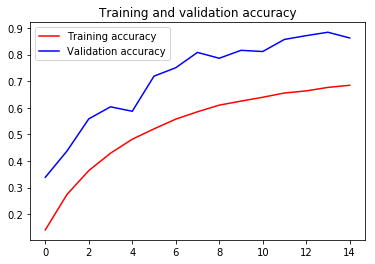

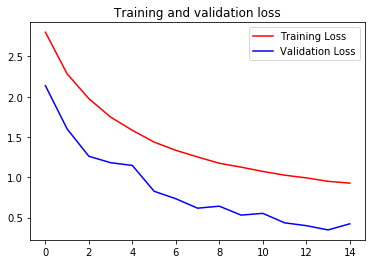

In [26]:
# Plot the chart for accuracy and loss on both training and validation
print(history)

import matplotlib.pyplot as plt
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Step - 4: Testing the Model

In [27]:
# create a python dictionary for the letters in the alphabet
import string
alphabet = string.ascii_uppercase
al_key = {i:a for i, a in enumerate(alphabet)}
print(al_key)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [28]:
# selecting 10 random images from the validation set
idx = np.random.choice(len(testing_labels), size=10, replace=False)
test_images = testing_images[idx]
test_labels = testing_labels[idx]

print(test_images.shape)
print(test_labels.shape)

(10, 28, 28, 1)
(10,)


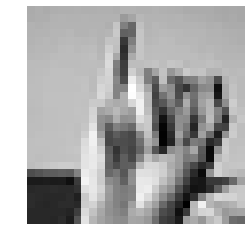

The model guess the above sign to be S, and the sign is I, therefore the model's is incorrect :(!


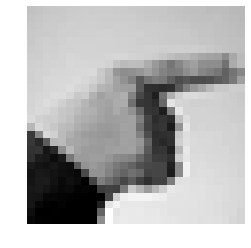

The model guess the above sign to be X, and the sign is G, therefore the model's is incorrect :(!


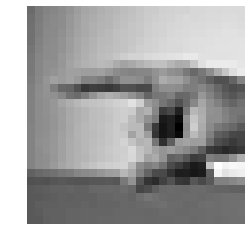

The model guess the above sign to be M, and the sign is P, therefore the model's is incorrect :(!


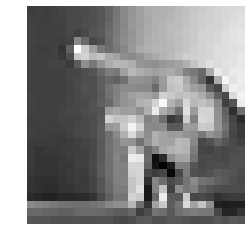

The model guess the above sign to be S, and the sign is P, therefore the model's is incorrect :(!


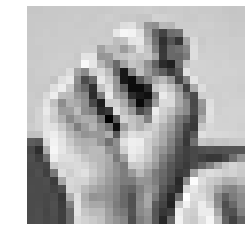

The model guess the above sign to be N, and the sign is N, therefore the model's is correct :)!


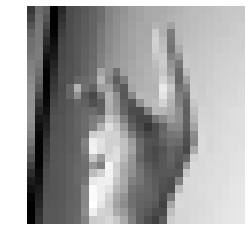

The model guess the above sign to be Q, and the sign is K, therefore the model's is incorrect :(!


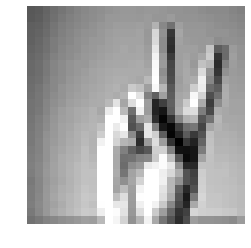

The model guess the above sign to be S, and the sign is V, therefore the model's is incorrect :(!


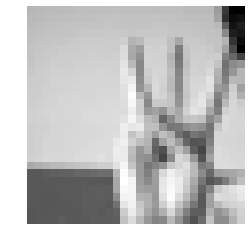

The model guess the above sign to be M, and the sign is W, therefore the model's is incorrect :(!


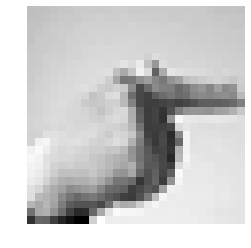

The model guess the above sign to be X, and the sign is T, therefore the model's is incorrect :(!


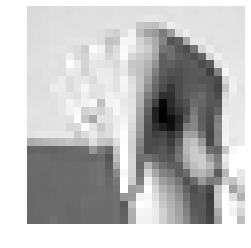

The model guess the above sign to be Q, and the sign is Q, therefore the model's is correct :)!


In [29]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

for image, label in zip(test_images, test_labels):
  img = image.reshape(28, 28)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()
  
  p = model.predict(np.expand_dims(image, axis=0))
  predict = np.argmax(p)
  is_correct = 'correct :)!' if predict==label else 'incorrect :(!'
  
  print('The model guess the above sign to be {}, and the sign is {}, '
        "therefore the model's is {}".format(al_key[predict], 
                                             al_key[int(label)],
                                             is_correct))